# 패키지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVC
from catboost import CatBoostRegressor, Pool
from ngboost import NGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()
from datetime import timedelta
import datetime as dt

C:\AI\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\AI\venv\lib\site-packages\pkg_resources\__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2-msvc is an invalid version and will not be supported in a future release
  warnings.warn(


# DATA LOAD

In [4]:
import pandas as pd
train = pd.read_csv("./dataset/train.csv",parse_dates=['일자'])
test  = pd.read_csv("./dataset/test.csv",parse_dates=['일자'])

# EDA & Feature Engineering

* 특정요일의 식사수 확인
* ex) 공휴일 전 저녁식사 급감 or 수요일 금요일 저녁식사 수 유의미한 변화 
* 재택근무가 늘어남에 따라 식사 감소 또한 확인
* 요일 오타 확인
* 특정한 요일 전후로 휴가 사용자수 변화에 따라 식사계가 얼마나 급격하게 변하는지  확인 해 볼 필요가 있다.
* 전체 사원수-재택근무자 -휴가근무자 -출장근무자 = 새로운 인원수로 변수로 둬볼 생각을 해 보자
* 2016년 10월 국정감사로인한 석식계가 급격하게 늘어난 사례.


## 전처리 한번에 하기 위해서 train,test 합치기

In [5]:
train_test=pd.concat([train,test],axis=0)
train_test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


## 날짜(연,월,일) Feature 추가
* 연, 월, 일에 따른 주기를 반영하기 위해 날짜 Feature 추가
* 요일이 안 맞는 데이터 하나 확인 -> 요일_찐 Feature로 교체

In [6]:
train_test['연']=train_test['일자'].dt.year
train_test['월']=train_test['일자'].dt.month
train_test['일']=train_test['일자'].dt.day
train_test=train_test.drop(['조식메뉴','중식메뉴','석식메뉴'],axis=1)

In [7]:
train_test['요일_찐']=train_test['일자'].dt.weekday

In [8]:
train_test.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐
0,2016-02-01,월,2601,50,150,238,0.0,1039.0,331.0,2016,2,1,0


## 공공데이터 API <공휴일>

In [9]:
import requests
import datetime
from bs4 import BeautifulSoup
import urllib.parse as urlparse


def get_request_query(url, operation, params, serviceKey):
    params = urlparse.urlencode(params)
    request_query = url + '/' + operation + '?' + params + '&' + 'serviceKey' + '=' + serviceKey
    return request_query

In [10]:
mykey = "zZY98%2ByWMsSMzfkUNHBrfqulJeTKpCstHxje8ErDvdKAcHa9g%2BydeAO9cUMxg4uHxwI6JzJR4Jl8SFBZskkUEg%3D%3D"
url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService'
operation = 'getRestDeInfo'
year = '2021'
month = '09'

params = {'solYear':year, 'solMonth':month}

request_query = get_request_query(url, operation, params, mykey)
print(request_query)

http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?solYear=2021&solMonth=09&serviceKey=zZY98%2ByWMsSMzfkUNHBrfqulJeTKpCstHxje8ErDvdKAcHa9g%2BydeAO9cUMxg4uHxwI6JzJR4Jl8SFBZskkUEg%3D%3D


In [11]:
res = requests.get(request_query)
soup = BeautifulSoup(res.text, 'lxml')
items = soup.find_all('item')
df = pd.DataFrame()
for year in [2016,2017,2018,2019,2020,2021]:
    for month in range(1,13):

        if month < 10:
            month = '0' + str(month)
        else:
            month = str(month)
        params = {'solYear':year, 'solMonth':month}

        request_query = get_request_query(url, operation, params, mykey)

        res = requests.get(request_query)
        soup = BeautifulSoup(res.text, 'lxml')
        items = soup.find_all('item')

        for item in items:
            day = item.locdate.get_text()
            name = item.datename.get_text()
            data = {'휴일이름':name , '날짜':day}
            df = df.append(data, ignore_index=True)
    
display(df.head())
display(df.tail())

,휴일이름,날짜
0,신정,20160101
1,설날,20160207
2,설날,20160208
3,설날,20160209
4,대체공휴일,20160210


,휴일이름,날짜
101,개천절,20211003
102,대체공휴일,20211004
103,한글날,20211009
104,대체공휴일,20211011
105,기독탄신일,20211225


### 근로자의 날 추가

* 공휴일 API 상으로는 근로자의 날이 반영되어있지 않음

In [12]:
df.loc[93]=['근로자의날','2016-05-01']
df.loc[94]=['근로자의날','2017-05-01']
df.loc[95]=['근로자의날','2018-05-01']
df.loc[96]=['근로자의날','2019-05-01']
df.loc[97]=['근로자의날','2020-05-01']

In [13]:
df['날짜']=pd.to_datetime(df['날짜'])

In [14]:
df['요일']=df['날짜'].dt.weekday

In [15]:
df.head()

,휴일이름,날짜,요일
0,신정,2016-01-01,4
1,설날,2016-02-07,6
2,설날,2016-02-08,0
3,설날,2016-02-09,1
4,대체공휴일,2016-02-10,2


## 개꿀날짜 구하기

* 휴일 전/후 여부, 이날 휴가가면 연휴 여부(개꿀가능성) Feature 추가

In [16]:
df['휴일전날']=df['날짜']-timedelta(days=1)
df['휴일다음날']=df['날짜']+timedelta(days=1)

In [17]:
df['다음날휴가면연휴']= 0
df['전날휴가면연휴']= 0
df[df['요일']==3].index
df.loc[df[df['요일']==3].index,['다음날휴가면연휴']]=1
df.loc[df[df['요일']==1].index,['전날휴가면연휴']]=1

In [18]:
honey_df=pd.concat([df.loc[df[df['전날휴가면연휴']==1].index,['날짜']]-timedelta(days=1),
                    df.loc[df[df['다음날휴가면연휴']==1].index,['날짜']]+timedelta(days=1)],axis=0)
honey_df=honey_df.reset_index().drop('index',axis=1)

In [19]:
df.head()

,휴일이름,날짜,요일,휴일전날,휴일다음날,다음날휴가면연휴,전날휴가면연휴
0,신정,2016-01-01,4,2015-12-31,2016-01-02,0,0
1,설날,2016-02-07,6,2016-02-06,2016-02-08,0,0
2,설날,2016-02-08,0,2016-02-07,2016-02-09,0,0
3,설날,2016-02-09,1,2016-02-08,2016-02-10,0,1
4,대체공휴일,2016-02-10,2,2016-02-09,2016-02-11,0,0


In [20]:
train_test['개꿀가능성'] = train_test['일자'].apply(lambda x : 1 if x in honey_df.values else 0)
train_test['휴일전날'] = train_test['일자'].apply(lambda x : 1 if x in df['휴일전날'].values else 0)
train_test['휴일다음날'] = train_test['일자'].apply(lambda x : 1 if x in df['휴일다음날'].values else 0)

In [21]:
train_test['개꿀가능성'].value_counts()

0    1241
1      14
Name: 개꿀가능성, dtype: int64

In [22]:
train_test[train_test['개꿀가능성']==1]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날
17,2016-02-29,월,2601,595,168,110,0.0,869.0,344.0,2016,2,29,0,1,1,0
311,2017-05-08,월,2637,715,130,151,0.0,792.0,308.0,2017,5,8,0,1,1,0
330,2017-06-05,월,2648,633,150,174,0.0,760.0,306.0,2017,6,5,0,1,1,0
379,2017-08-14,월,2645,863,131,114,0.0,692.0,275.0,2017,8,14,0,1,1,0
511,2018-03-02,금,2714,840,206,57,0.0,508.0,349.0,2018,3,2,4,1,0,1
552,2018-04-30,월,2714,646,180,107,0.0,629.0,317.0,2018,4,30,0,1,1,0
565,2018-05-21,월,2721,861,144,139,0.0,543.0,234.0,2018,5,21,0,1,1,0
651,2018-10-08,월,2805,424,233,216,0.0,895.0,442.0,2018,10,8,0,1,1,0
705,2018-12-24,월,2846,894,159,26,0.0,296.0,104.0,2018,12,24,0,1,1,0
709,2018-12-31,월,2846,1085,132,28,0.0,332.0,135.0,2018,12,31,0,1,1,0


## 기념일 처리
* 같은 공휴일 전날 중에서도 연말/크리스마스 이브가 데이터상으로 유의미함 -> 따로 처리

In [23]:
train_test['기념일']=0

In [24]:
train_test.iloc[train_test[(train_test['월']==12)&(train_test['일']==24)].index,13]=1 #크리스마스 이브 처리
train_test.iloc[train_test[(train_test['월']==12)&(train_test['일']==31)].index,13]=1 #연말 처리

In [25]:
train_test[(train_test['월']==12)&(train_test['일']==31)]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일
709,2018-12-31,월,2846,1085,132,28,0.0,332.0,135.0,2018,12,31,0,1,1,0,0
955,2019-12-31,화,3111,709,149,22,0.0,349.0,0.0,2019,12,31,1,1,1,0,0


In [26]:
train_test['요일'].value_counts()

목    254
금    251
월    250
화    250
수    250
Name: 요일, dtype: int64

## 요일 오타 처리

In [27]:
train_test['요일'].replace(['월','화','수','목','금'],[0,1,2,3,4], inplace=True)

잘못된 날짜 데이터 존재함

In [28]:
train_test[train_test['요일']!=train_test['요일_찐']]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일
573,2018-06-01,0,2728,180,291,55,0.0,649.0,395.0,2018,6,1,4,0,0,0,0


In [29]:
train_test['요일']=train_test['요일_찐']
train_test=train_test.drop('요일',axis=1)

In [30]:
train_test.head()

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일
0,2016-02-01,2601,50,150,238,0.0,1039.0,331.0,2016,2,1,0,0,0,0,0
1,2016-02-02,2601,50,173,319,0.0,867.0,560.0,2016,2,2,1,0,0,0,0
2,2016-02-03,2601,56,180,111,0.0,1017.0,573.0,2016,2,3,2,0,0,0,0
3,2016-02-04,2601,104,220,355,0.0,978.0,525.0,2016,2,4,3,0,0,0,0
4,2016-02-05,2601,278,181,34,0.0,925.0,330.0,2016,2,5,4,0,0,0,0


## 국정감사 기간 처리하기

In [133]:
gukgam = pd.to_datetime(['2016-10-04', '2016-10-05', '2016-10-06', '2017-10-10', '2017-10-11', '2017-10-12', '2017-10-13', '2018-10-08', '2018-10-10', '2018-10-11',\
                             '2019-10-02', '2019-10-04','2020-10-07','2020-10-08'])
train_test['국정감사'] = train_test['일자'].apply(lambda x : 1 if x in gukgam else 0)
train_test[train_test['국정감사']==1].head()

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
163,2016-10-04,2670,-0.687098,239,1035,-0.450528,1262.0,902.0,2016,10,4,1,-0.117183,-0.183773,5.126657,0,1,2611.0
164,2016-10-05,2670,-0.813580,228,0,-0.450528,1336.0,905.0,2016,10,5,2,-0.117183,-0.183773,-0.195059,0,1,2629.0
165,2016-10-06,2670,-0.708178,245,378,-0.450528,1196.0,352.0,2016,10,6,3,-0.117183,-0.183773,-0.195059,0,1,2614.0
413,2017-10-10,2645,-0.363865,209,641,-0.450528,1265.0,746.0,2017,10,10,1,-0.117183,-0.183773,5.126657,0,1,2540.0
414,2017-10-11,2645,-0.680071,250,0,-0.450528,1109.0,613.0,2017,10,11,2,-0.117183,-0.183773,-0.195059,0,1,2585.0


* 데이터는 월,화,목에 야근을 하는 패턴을 보임
* 2019년 이전 국정감사에서는 야근자가 1000명이 넘는데 2019년 이후 부터는 평소 패턴과 큰 차이를 발견하기 힘듬

In [134]:
train_test[(train_test['요일_찐']!=0)&(train_test['요일_찐']!=1)&(train_test['요일_찐']!=3)&(train_test['본사시간외근무명령서승인건수']>100)].head() 
#월화목이외 야근자수가 많은 이상치
#2019년 이후 조건에 맞는 데이터가 없음 -> 노동법이 개편되었거나 여타 이유로 '월화목' 이외의 야근이 불가능한 상황인듯

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
2,2016-02-03,2601,-0.708178,180,111,-0.450528,1017.0,573.0,2016,2,3,2,-0.117183,-0.183773,-0.195059,0,0,2545.0
18,2016-03-02,2624,-0.209275,182,261,-0.450528,1127.0,631.0,2016,3,2,2,-0.117183,-0.183773,5.126657,0,0,2497.0
171,2016-10-14,2670,-0.089820,265,172,-0.450528,898.0,544.0,2016,10,14,4,-0.117183,-0.183773,-0.195059,0,0,2526.0
206,2016-12-02,2705,0.184225,272,152,-0.450528,766.0,448.0,2016,12,2,4,-0.117183,-0.183773,-0.195059,0,0,2522.0
211,2016-12-09,2705,0.275574,284,152,-0.450528,621.0,416.0,2016,12,9,4,-0.117183,-0.183773,-0.195059,0,0,2509.0


In [33]:
train_test.loc[1132:1133,['국정감사']]=0 #2020년 국정감사 데이터 체크 해제

In [135]:
gukgam = pd.to_datetime(['2016-10-04', '2016-10-05', '2016-10-06', '2017-10-10', '2017-10-11', '2017-10-12', '2017-10-13', '2018-10-08', '2018-10-10', '2018-10-11',\
                             '2019-10-02', '2019-10-04','2020-10-07','2020-10-08'])
train_test['국정감사'] = train_test['일자'].apply(lambda x : 1 if x in gukgam else 0)
train_test[train_test['국정감사']==1].head()

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
163,2016-10-04,2670,-0.687098,239,1035,-0.450528,1262.0,902.0,2016,10,4,1,-0.117183,-0.183773,5.126657,0,1,2611.0
164,2016-10-05,2670,-0.813580,228,0,-0.450528,1336.0,905.0,2016,10,5,2,-0.117183,-0.183773,-0.195059,0,1,2629.0
165,2016-10-06,2670,-0.708178,245,378,-0.450528,1196.0,352.0,2016,10,6,3,-0.117183,-0.183773,-0.195059,0,1,2614.0
413,2017-10-10,2645,-0.363865,209,641,-0.450528,1265.0,746.0,2017,10,10,1,-0.117183,-0.183773,5.126657,0,1,2540.0
414,2017-10-11,2645,-0.680071,250,0,-0.450528,1109.0,613.0,2017,10,11,2,-0.117183,-0.183773,-0.195059,0,1,2585.0


## 자기계발의 날 삭제하기
* 마지막 주 수요일, 없으면 화요일로 진행되는 듯함
* 근데 2020년 이후로 안하는 듯
* 중식계 구할때는 남겨놔야할 듯 (학습)

In [35]:
train_test[train_test['석식계']==0] #석식계가 0인 날은 전부 자기계발의 날임

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사
204,2016-11-30,2689,68,207,0,0.0,1109.0,0.0,2016,11,30,2,0,0,0,0,0
224,2016-12-28,2705,166,225,0,0.0,767.0,0.0,2016,12,28,2,0,0,0,0,0
244,2017-01-25,2697,79,203,0,0.0,720.0,0.0,2017,1,25,2,0,0,0,0,0
262,2017-02-22,2632,75,252,0,0.0,1065.0,0.0,2017,2,22,2,0,0,0,0,0
281,2017-03-22,2627,53,235,0,0.0,953.0,0.0,2017,3,22,2,0,0,0,0,0
306,2017-04-26,2626,45,304,0,0.0,835.0,0.0,2017,4,26,2,0,0,0,0,0
327,2017-05-31,2637,43,265,0,0.0,910.0,0.0,2017,5,31,2,0,0,0,0,0
346,2017-06-28,2648,58,259,0,0.0,745.0,0.0,2017,6,28,2,0,0,0,0,0
366,2017-07-26,2839,254,246,0,0.0,797.0,0.0,2017,7,26,2,0,0,0,0,0
392,2017-09-01,2642,177,303,45,0.0,663.0,0.0,2017,9,1,4,0,0,0,0,0


## Feature 대면출근자(정원 - 휴가자 - 재택)



In [36]:
train_test['대면출근자']=train_test['본사정원수']-train_test['본사휴가자수']-train_test['현본사소속재택근무자수']

In [37]:
train_test[(train_test['월']==12)&(train_test['일']==31)]

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
709,2018-12-31,2846,1085,132,28,0.0,332.0,135.0,2018,12,31,0,1,1,0,0,0,1761.0
955,2019-12-31,3111,709,149,22,0.0,349.0,0.0,2019,12,31,1,1,1,0,0,0,2402.0


## Feature Covid19 (코로나 기간 처리) -다중공선

In [212]:
train_test['코로나기간']=0

In [205]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 49
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1255 non-null   datetime64[ns]
 1   본사정원수           1255 non-null   int64         
 2   본사휴가자수          1255 non-null   float64       
 3   본사출장자수          1255 non-null   int64         
 4   본사시간외근무명령서승인건수  1255 non-null   int64         
 5   현본사소속재택근무자수     1255 non-null   float64       
 6   중식계             1205 non-null   float64       
 7   석식계             1205 non-null   float64       
 8   연               1255 non-null   int64         
 9   월               1255 non-null   int64         
 10  일               1255 non-null   int64         
 11  요일_찐            1255 non-null   int64         
 12  개꿀가능성           1255 non-null   float64       
 13  휴일전날            1255 non-null   float64       
 14  휴일다음날           1255 non-null   float64       
 15  기념일   

In [209]:
train_test[train_test['일자']>'2020-03-25'].index

Int64Index([1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
            ...
              40,   41,   42,   43,   44,   45,   46,   47,   48,   49],
           dtype='int64', length=241)

In [214]:
train_test.iloc[1014:,18]=1
train_test.head()

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자,코로나기간
0,2016-02-01,2601,-0.750339,150,238,-0.450528,1039.0,331.0,2016,2,1,0,-0.117183,-0.183773,-0.195059,0,0,2551.0,0
1,2016-02-02,2601,-0.750339,173,319,-0.450528,867.0,560.0,2016,2,2,1,-0.117183,-0.183773,-0.195059,0,0,2551.0,0
2,2016-02-03,2601,-0.708178,180,111,-0.450528,1017.0,573.0,2016,2,3,2,-0.117183,-0.183773,-0.195059,0,0,2545.0,0
3,2016-02-04,2601,-0.370892,220,355,-0.450528,978.0,525.0,2016,2,4,3,-0.117183,-0.183773,-0.195059,0,0,2497.0,0
4,2016-02-05,2601,0.851771,181,34,-0.450528,925.0,330.0,2016,2,5,4,-0.117183,-0.183773,-0.195059,0,0,2323.0,0


## 시각화

In [38]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic') 

<AxesSubplot:>

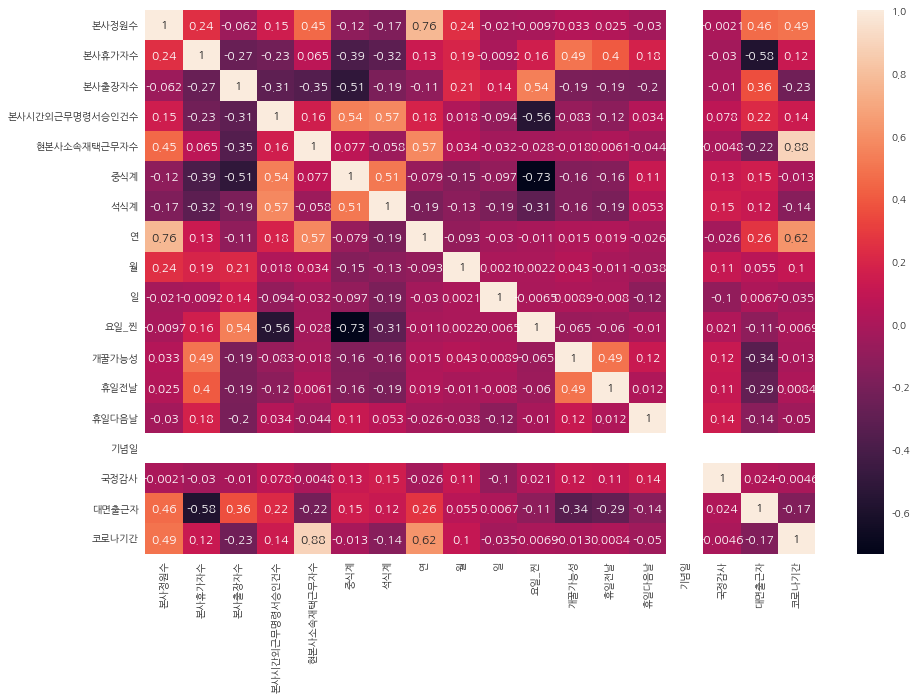

In [249]:
plt.figure(figsize=(15,10))
plt.rc('font', family='NanumGothic') 
sns.heatmap(train_test[train_test['중식계'].isna()==False].corr(),annot=True)

* 다중공선성 가능성은 딱히 없어보임

In [40]:
train_test.head()

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
0,2016-02-01,2601,50,150,238,0.0,1039.0,331.0,2016,2,1,0,0,0,0,0,0,2551.0
1,2016-02-02,2601,50,173,319,0.0,867.0,560.0,2016,2,2,1,0,0,0,0,0,2551.0
2,2016-02-03,2601,56,180,111,0.0,1017.0,573.0,2016,2,3,2,0,0,0,0,0,2545.0
3,2016-02-04,2601,104,220,355,0.0,978.0,525.0,2016,2,4,3,0,0,0,0,0,2497.0
4,2016-02-05,2601,278,181,34,0.0,925.0,330.0,2016,2,5,4,0,0,0,0,0,2323.0


<AxesSubplot:xlabel='일자', ylabel='대면출근자'>

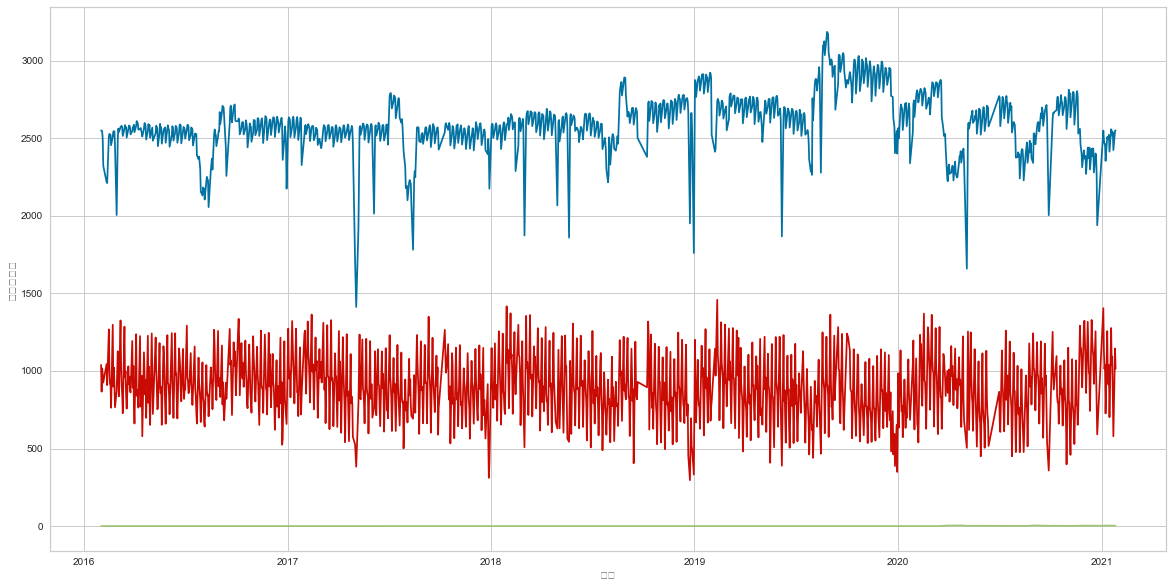

In [140]:
plt.figure(figsize=(20,10))
sns.lineplot(x='일자', y='대면출근자', data=train_test[train_test['중식계'].isna()==False])
sns.lineplot(x='일자', y='현본사소속재택근무자수', data=train_test[train_test['중식계'].isna()==False])
sns.lineplot(x='일자', y='중식계', data=train_test[train_test['중식계'].isna()==False])

<AxesSubplot:xlabel='일자', ylabel='중식계'>

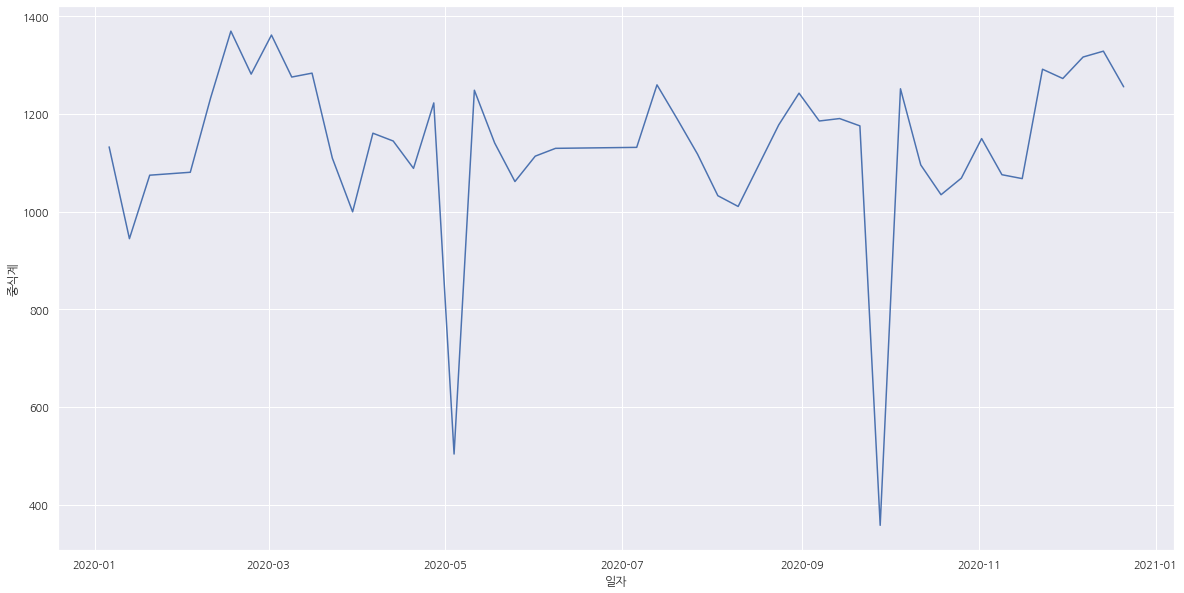

In [42]:
plt.figure(figsize=(20,10))
sns.lineplot(x='일자', y='중식계', data=train_test[(train_test['중식계'].isna()==False)&(train_test['연']==2020)&(train_test['요일_찐']==0)])


In [43]:
train_test[train_test['대면출근자']<2000]

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
309,2017-05-02,2637,933,123,88,0.0,525.0,298.0,2017,5,2,1,0,1,1,0,0,1704.0
310,2017-05-04,2637,1224,41,45,0.0,383.0,262.0,2017,5,4,3,0,1,1,0,0,1413.0
311,2017-05-08,2637,715,130,151,0.0,792.0,308.0,2017,5,8,0,1,1,0,0,0,1922.0
379,2017-08-14,2645,863,131,114,0.0,692.0,275.0,2017,8,14,0,1,1,0,0,0,1782.0
511,2018-03-02,2714,840,206,57,0.0,508.0,349.0,2018,3,2,4,1,0,1,0,0,1874.0
565,2018-05-21,2721,861,144,139,0.0,543.0,234.0,2018,5,21,0,1,1,0,0,0,1860.0
705,2018-12-24,2846,894,159,26,0.0,296.0,104.0,2018,12,24,0,1,1,0,0,0,1952.0
709,2018-12-31,2846,1085,132,28,0.0,332.0,135.0,2018,12,31,0,1,1,0,0,0,1761.0
815,2019-06-07,2758,890,219,3,0.0,389.0,244.0,2019,6,7,4,1,0,1,0,0,1868.0
1038,2020-05-04,2962,1113,117,91,189.0,504.0,123.0,2020,5,4,0,1,1,0,0,0,1660.0


# 스케일링

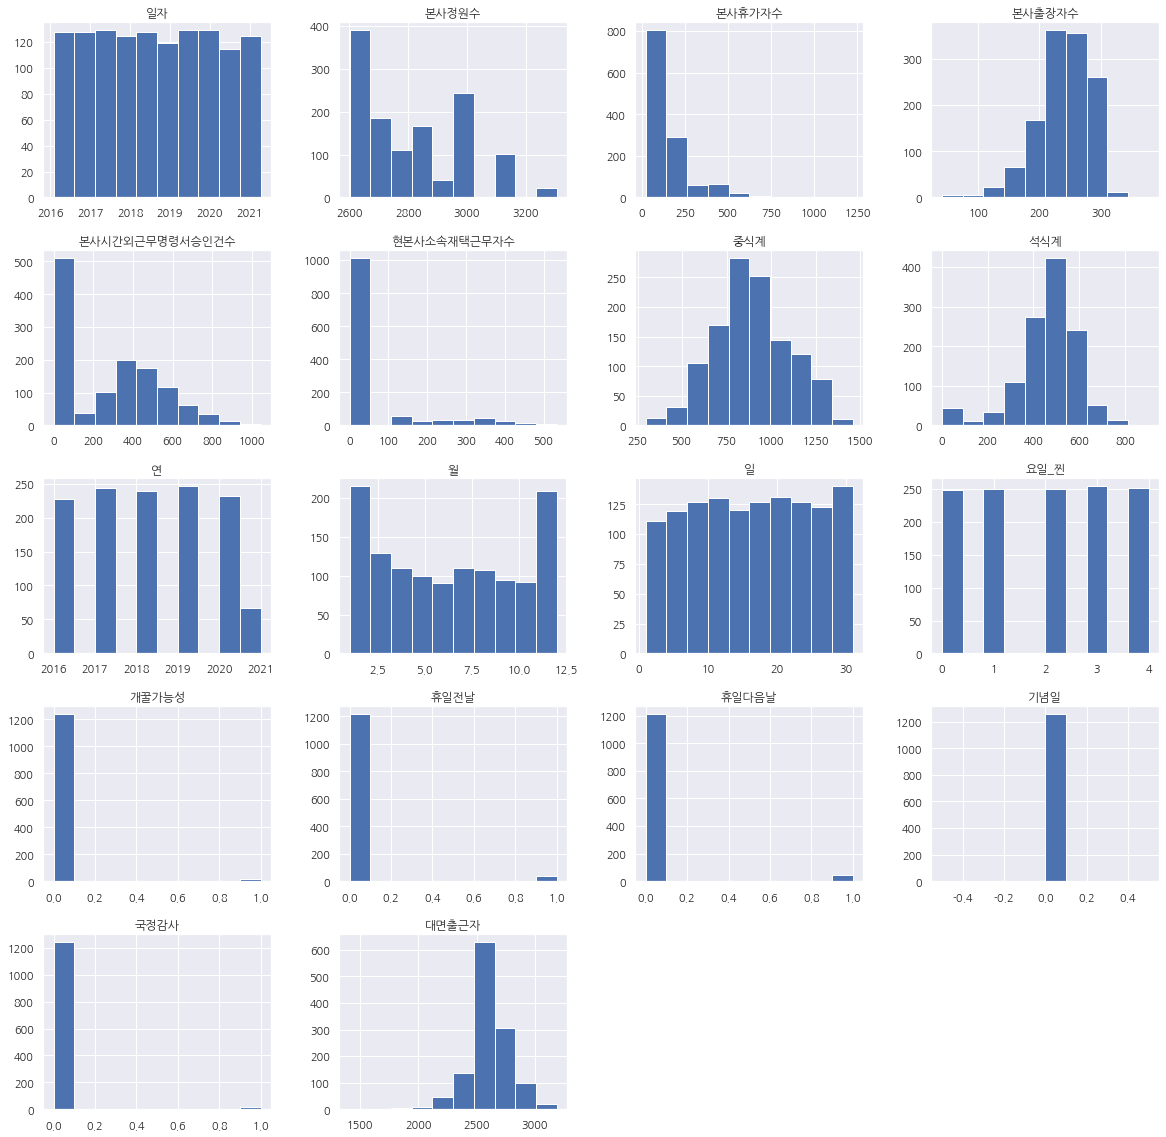

In [44]:
train_test.hist(figsize=(20,20))
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [46]:
col_list = train_test.skew()[train_test.skew()>2].index
print(col_list)

Index(['본사휴가자수', '현본사소속재택근무자수', '개꿀가능성', '휴일전날', '휴일다음날', '국정감사'], dtype='object')


In [47]:
col_list = train_test.skew()[train_test.skew()>2].index
scaler = StandardScaler()
train_test[col_list] = scaler.fit_transform(train_test[col_list])
train_test.head()

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
0,2016-02-01,2601,-0.750339,150,238,-0.450528,1039.0,331.0,2016,2,1,0,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
1,2016-02-02,2601,-0.750339,173,319,-0.450528,867.0,560.0,2016,2,2,1,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
2,2016-02-03,2601,-0.708178,180,111,-0.450528,1017.0,573.0,2016,2,3,2,-0.117183,-0.183773,-0.195059,0,-0.106213,2545.0
3,2016-02-04,2601,-0.370892,220,355,-0.450528,978.0,525.0,2016,2,4,3,-0.117183,-0.183773,-0.195059,0,-0.106213,2497.0
4,2016-02-05,2601,0.851771,181,34,-0.450528,925.0,330.0,2016,2,5,4,-0.117183,-0.183773,-0.195059,0,-0.106213,2323.0


In [48]:
train_lunch=train_test[train_test['중식계'].isna()==False].drop(['석식계','일자','본사정원수'],axis=1)
train_lunch.head()

,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
0,-0.750339,150,238,-0.450528,1039.0,2016,2,1,0,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
1,-0.750339,173,319,-0.450528,867.0,2016,2,2,1,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
2,-0.708178,180,111,-0.450528,1017.0,2016,2,3,2,-0.117183,-0.183773,-0.195059,0,-0.106213,2545.0
3,-0.370892,220,355,-0.450528,978.0,2016,2,4,3,-0.117183,-0.183773,-0.195059,0,-0.106213,2497.0
4,0.851771,181,34,-0.450528,925.0,2016,2,5,4,-0.117183,-0.183773,-0.195059,0,-0.106213,2323.0


In [49]:
train_dinner=train_test[(train_test['석식계'].isna()==False)&(train_test['석식계']!=0)].drop(['중식계','일자','본사정원수'],axis=1)
train_dinner.head()

,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
0,-0.750339,150,238,-0.450528,331.0,2016,2,1,0,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
1,-0.750339,173,319,-0.450528,560.0,2016,2,2,1,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
2,-0.708178,180,111,-0.450528,573.0,2016,2,3,2,-0.117183,-0.183773,-0.195059,0,-0.106213,2545.0
3,-0.370892,220,355,-0.450528,525.0,2016,2,4,3,-0.117183,-0.183773,-0.195059,0,-0.106213,2497.0
4,0.851771,181,34,-0.450528,330.0,2016,2,5,4,-0.117183,-0.183773,-0.195059,0,-0.106213,2323.0


In [50]:
testfortest=train_test[train_test['중식계'].isna()==True].drop(['중식계','석식계','일자','본사정원수'],axis=1)
testfortest

,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
0,-0.483321,182,5,2.555735,2021,1,27,2,-0.117183,-0.183773,-0.195059,0,-0.106213,2537.0
1,-0.370892,212,409,2.471761,2021,1,28,3,-0.117183,-0.183773,-0.195059,0,-0.106213,2531.0
2,0.795557,249,0,2.018302,2021,1,29,4,-0.117183,-0.183773,-0.195059,0,-0.106213,2419.0
3,-0.342785,154,538,2.253429,2021,2,1,0,-0.117183,-0.183773,-0.195059,0,-0.106213,2494.0
4,-0.666017,186,455,2.186250,2021,2,2,1,-0.117183,-0.183773,-0.195059,0,-0.106213,2548.0
5,-0.687098,199,5,1.951123,2021,2,3,2,-0.117183,-0.183773,-0.195059,0,-0.106213,2579.0
6,-0.673044,211,476,1.967918,2021,2,4,3,-0.117183,-0.183773,-0.195059,0,-0.106213,2575.0
7,0.085850,252,0,1.699202,2021,2,5,4,-0.117183,-0.183773,-0.195059,0,-0.106213,2499.0
8,-0.483321,174,690,2.312211,2021,2,8,0,-0.117183,-0.183773,-0.195059,0,-0.106213,2507.0
9,-0.441160,183,542,2.312211,2021,2,9,1,-0.117183,-0.183773,-0.195059,0,-0.106213,2501.0


In [51]:
preddf=pd.DataFrame(data=test['일자'],columns=['일자'])
preddf

,일자
0,2021-01-27
1,2021-01-28
2,2021-01-29
3,2021-02-01
4,2021-02-02
5,2021-02-03
6,2021-02-04
7,2021-02-05
8,2021-02-08
9,2021-02-09


In [52]:
train_lunch.head()

,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
0,-0.750339,150,238,-0.450528,1039.0,2016,2,1,0,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
1,-0.750339,173,319,-0.450528,867.0,2016,2,2,1,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
2,-0.708178,180,111,-0.450528,1017.0,2016,2,3,2,-0.117183,-0.183773,-0.195059,0,-0.106213,2545.0
3,-0.370892,220,355,-0.450528,978.0,2016,2,4,3,-0.117183,-0.183773,-0.195059,0,-0.106213,2497.0
4,0.851771,181,34,-0.450528,925.0,2016,2,5,4,-0.117183,-0.183773,-0.195059,0,-0.106213,2323.0


In [53]:
train_lunch.columns

Index(['본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식계', '연', '월',
       '일', '요일_찐', '개꿀가능성', '휴일전날', '휴일다음날', '기념일', '국정감사', '대면출근자'],
      dtype='object')

In [54]:
cat_col=[4,5,6,7,8,9,10,11,12]

In [55]:
cat_col

[4, 5, 6, 7, 8, 9, 10, 11, 12]

In [56]:
train_lunch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   본사휴가자수          1205 non-null   float64
 1   본사출장자수          1205 non-null   int64  
 2   본사시간외근무명령서승인건수  1205 non-null   int64  
 3   현본사소속재택근무자수     1205 non-null   float64
 4   중식계             1205 non-null   float64
 5   연               1205 non-null   int64  
 6   월               1205 non-null   int64  
 7   일               1205 non-null   int64  
 8   요일_찐            1205 non-null   int64  
 9   개꿀가능성           1205 non-null   float64
 10  휴일전날            1205 non-null   float64
 11  휴일다음날           1205 non-null   float64
 12  기념일             1205 non-null   int64  
 13  국정감사            1205 non-null   float64
 14  대면출근자           1205 non-null   float64
dtypes: float64(8), int64(7)
memory usage: 150.6 KB


In [57]:
from catboost import CatBoostClassifier, Pool, cv

In [58]:
train_lunch[['개꿀가능성', '휴일전날', '휴일다음날', '기념일', '국정감사']]=train_lunch[['개꿀가능성', '휴일전날', '휴일다음날', '기념일', '국정감사']].astype('int')

In [59]:
y = train_lunch['중식계']
X = train_lunch.drop(['중식계'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)

In [60]:
X_train.isna().sum()

본사휴가자수            0
본사출장자수            0
본사시간외근무명령서승인건수    0
현본사소속재택근무자수       0
연                 0
월                 0
일                 0
요일_찐              0
개꿀가능성             0
휴일전날              0
휴일다음날             0
기념일               0
국정감사              0
대면출근자             0
dtype: int64

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 230 to 815
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   본사휴가자수          964 non-null    float64
 1   본사출장자수          964 non-null    int64  
 2   본사시간외근무명령서승인건수  964 non-null    int64  
 3   현본사소속재택근무자수     964 non-null    float64
 4   연               964 non-null    int64  
 5   월               964 non-null    int64  
 6   일               964 non-null    int64  
 7   요일_찐            964 non-null    int64  
 8   개꿀가능성           964 non-null    int32  
 9   휴일전날            964 non-null    int32  
 10  휴일다음날           964 non-null    int32  
 11  기념일             964 non-null    int32  
 12  국정감사            964 non-null    int32  
 13  대면출근자           964 non-null    float64
dtypes: float64(3), int32(5), int64(6)
memory usage: 94.1 KB


In [62]:
-63.62429280725864
-63.62429280725864

-63.62429280725864

In [63]:

train_pool = Pool(X_train,y_train, cat_features=cat_col)
model=CatBoostRegressor(depth = 4, random_state = 42, loss_function = 'MAE', n_estimators = 3000, learning_rate = 0.03, verbose = 0)
maescore=cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print(model.__class__.__name__,':',np.mean(maescore),)
model.fit(X_train,y_train, cat_features=cat_col)
#preddf[model.__class__.__name__] = model.predict(testfortest)

CatBoostRegressor : -63.62429280725864


In [64]:
def my_fit_score(df,target):
    y = df[target]
    X = df.drop([target], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)
    model_list = [LinearRegression(),Lasso(),ElasticNet(),Ridge(),
                  XGBRegressor(),
                  NGBRegressor(random_state = 42, n_estimators = 1000, verbose = 0, learning_rate = 0.03)]
    for model in model_list:
        global preddf
        maescore=cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
        print(model.__class__.__name__,':',np.mean(maescore),)
        model.fit(X_train, y_train)
        preddf[model.__class__.__name__] = model.predict(testfortest)

In [65]:
my_fit_score(train_lunch,'중식계')

LinearRegression : -81.99286958576124
Lasso : -82.08726143963064
ElasticNet : -86.97017974058019
Ridge : -81.99004997017343
XGBRegressor : -70.80722743876035
NGBRegressor : -67.02681443865526


In [66]:
preddf

,일자,LinearRegression,Lasso,ElasticNet,Ridge,XGBRegressor,NGBRegressor
0,2021-01-27,956.399234,952.024989,925.247174,956.279672,977.117615,976.698314
1,2021-01-28,866.517593,864.520491,883.534636,866.556367,947.644653,926.382484
2,2021-01-29,644.546188,641.262450,651.087884,644.539686,556.057983,679.532964
3,2021-02-01,1186.307653,1183.612828,1148.520996,1186.169559,1188.597290,1234.139620
4,2021-02-02,1076.792221,1074.380530,1047.236637,1076.681286,1031.049805,932.296053
5,2021-02-03,947.487850,945.335578,909.226786,947.348114,1003.613098,916.410417
6,2021-02-04,893.926622,895.333927,914.865861,893.984881,907.713196,846.597809
7,2021-02-05,683.200180,682.340284,682.574150,683.177779,662.218872,677.222636
8,2021-02-08,1174.009182,1170.761311,1139.989769,1173.881284,1313.116821,1276.064194
9,2021-02-09,1073.131453,1070.798759,1051.287333,1073.044197,1084.976196,1050.354557


In [67]:
my_fit_score(train_lunch,'중식계')

LinearRegression : -81.99286958576124
Lasso : -82.08726143963064
ElasticNet : -86.97017974058019
Ridge : -81.99004997017343
XGBRegressor : -70.80722743876035
NGBRegressor : -66.99869782963874


In [68]:
my_fit_score(train_lunch,'중식계')  #성능 catboost->XGB->NGB 앙상블하자

LinearRegression : -81.99286958576124
Lasso : -82.08726143963064
ElasticNet : -86.97017974058019
Ridge : -81.99004997017343
XGBRegressor : -70.80722743876035
NGBRegressor : -67.01218245283805


In [69]:
preddf['중식계']=(preddf['XGBRegressor']*0.2)+(preddf['NGBRegressor']*0.2)+(preddf['CatBoostRegressor']*0.60)
preddf=preddf[['일자','중식계']]

KeyError: 'CatBoostRegressor'

In [70]:
train_dinner.head()

,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자
0,-0.750339,150,238,-0.450528,331.0,2016,2,1,0,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
1,-0.750339,173,319,-0.450528,560.0,2016,2,2,1,-0.117183,-0.183773,-0.195059,0,-0.106213,2551.0
2,-0.708178,180,111,-0.450528,573.0,2016,2,3,2,-0.117183,-0.183773,-0.195059,0,-0.106213,2545.0
3,-0.370892,220,355,-0.450528,525.0,2016,2,4,3,-0.117183,-0.183773,-0.195059,0,-0.106213,2497.0
4,0.851771,181,34,-0.450528,330.0,2016,2,5,4,-0.117183,-0.183773,-0.195059,0,-0.106213,2323.0


In [71]:
my_fit_score(train_dinner,'석식계')

LinearRegression : -52.82919619688712
Lasso : -52.82256684866353
ElasticNet : -53.43337452824678
Ridge : -52.82710150335207
XGBRegressor : -47.71102302992493
NGBRegressor : -44.491962346932716


In [72]:
preddf['석식계']=(preddf['XGBRegressor']*0.2)+(preddf['NGBRegressor']*0.2)+(preddf['CatBoostRegressor']*0.60)
preddf=preddf[['일자','중식계','석식계']]

KeyError: 'CatBoostRegressor'

In [ ]:
preddf.to_csv('/content/gdrive/My Drive/Colab Notebooks/comp/water/submit3.csv',index=False)

In [ ]:
covid_train_test=train_test.iloc[1010:]
covid_train_lunch=covid_train_test[covid_train_test['중식계'].isna()==False].drop(['석식계','일자'],axis=1)
covid_train_dinner=covid_train_test[covid_train_test['석식계'].isna()==False].drop(['중식계','일자'],axis=1)


In [ ]:
my_fit_score(covid_train_lunch,'중식계')

In [ ]:
preddf['중식계']=(preddf['XGBRegressor']*0.2)+(preddf['NGBRegressor']*0.2)+(preddf['CatBoostRegressor']*0.60)
preddf=preddf[['일자','중식계']]

In [ ]:
my_fit_score(covid_train_dinner,'석식계')

In [ ]:
preddf['석식계']=(preddf['XGBRegressor']*0.2)+(preddf['NGBRegressor']*0.2)+(preddf['CatBoostRegressor']*0.60)
preddf=preddf[['일자','중식계','석식계']]

In [ ]:
preddf.to_csv('/content/gdrive/My Drive/Colab Notebooks/comp/water/submit_covid.csv',index=False)

# 메뉴 가공

In [215]:
menu=pd.concat([train[['중식메뉴','석식메뉴']],test[['중식메뉴','석식메뉴']]],axis=0)

In [216]:
menu

,중식메뉴,석식메뉴
0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ..."
1,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무..."
2,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기..."
3,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포..."
4,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:..."
...,...,...
45,쌀밥/흑미밥/찰현미밥 쇠고기미역국 춘천닭갈비 오지치즈후라이 가지두반장볶음 포기김치 ...,흑미밥 돈육고추장찌개 갈치구이 김치전 취나물무침 깍두기
46,쌀밥/귀리밥/찰현미밥 순두부백탕 매콤소갈비찜 깻잎완자전 돌나물초장무침 포기김치 시리...,추가밥 짬뽕*생면 수제찹쌀꿔바로우 메추리알곤약장조림 단무지무침 포기김치
47,쌀밥/흑미밥/찰현미밥 냉이국 돈육간장불고기 비빔냉면 오이나물볶음 겉절이김치 양상추샐...,단호박카레라이스 시금치된장국 소떡소떡 파프리카해초무침 감귤쥬스 포기김치
48,쌀밥/옥수수밥/찰현미밥 맑은떡국 (New)로제찜닭 가자미구이*장 유채나물무침 포기김...,흑미밥 어묵매운탕 쇠고기숙주볶음 채소계란찜 쑥갓생무침 김치볶음


In [217]:
def get_token(data) :
    tokens = []
    for token in data :
        s_list = []
        for t in token :
            if t.startswith('(N') :
                s_list.append(t)
            elif (t.startswith('(') == False) & (len(t) > 1) :
                s_list.append(t)
            else :
                pass
        tokens.append(s_list)
    return tokens

In [218]:
menu['중식메뉴'] = menu['중식메뉴'].str.split(' ')
menu['석식메뉴'] = menu['석식메뉴'].str.split(' ')
menu['중식메뉴'] = get_token(menu['중식메뉴'])
menu['석식메뉴'] = get_token(menu['석식메뉴'])
menu


,중식메뉴,석식메뉴
0,"[쌀밥/잡곡밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]","[쌀밥/잡곡밥, 육개장, 자반고등어구이, 두부조림, 건파래무침, 포기김치]"
1,"[쌀밥/잡곡밥, 김치찌개, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추...","[콩나물밥*양념장, 어묵국, 유산슬, 아삭고추무침, 바나나, 포기김치]"
2,"[카레덮밥, 팽이장국, 치킨핑거, 쫄면야채무침, 견과류조림, 요구르트, 포기김치]","[쌀밥/잡곡밥, 청국장찌개, 황태양념구이, 고기전, 새송이버섯볶음, 포기김치]"
3,"[쌀밥/잡곡밥, 쇠고기무국, 주꾸미볶음, 부추전, 시금치나물, 요구르트, 포기김치]","[미니김밥*겨자장, 우동, 멕시칸샐러드, 군고구마, 무피클, 포기김치]"
4,"[쌀밥/잡곡밥, 떡국, 돈육씨앗강정, 우엉잡채, 청경채무침, 요구르트, 포기김치]","[쌀밥/잡곡밥, 차돌박이찌개, 닭갈비, 감자소세지볶음, 콩나물무침, 포기김치]"
...,...,...
45,"[쌀밥/흑미밥/찰현미밥, 쇠고기미역국, 춘천닭갈비, 오지치즈후라이, 가지두반장볶음,...","[흑미밥, 돈육고추장찌개, 갈치구이, 김치전, 취나물무침, 깍두기]"
46,"[쌀밥/귀리밥/찰현미밥, 순두부백탕, 매콤소갈비찜, 깻잎완자전, 돌나물초장무침, 포...","[추가밥, 짬뽕*생면, 수제찹쌀꿔바로우, 메추리알곤약장조림, 단무지무침, 포기김치]"
47,"[쌀밥/흑미밥/찰현미밥, 냉이국, 돈육간장불고기, 비빔냉면, 오이나물볶음, 겉절이김...","[단호박카레라이스, 시금치된장국, 소떡소떡, 파프리카해초무침, 감귤쥬스, 포기김치]"
48,"[쌀밥/옥수수밥/찰현미밥, 맑은떡국, (New)로제찜닭, 가자미구이*장, 유채나물무...","[흑미밥, 어묵매운탕, 쇠고기숙주볶음, 채소계란찜, 쑥갓생무침, 김치볶음]"


In [219]:
menu['중식_밥']=menu.중식메뉴.str[0]
menu['중식_메인요리'] = menu.중식메뉴.str[2]
menu['중식_국'] = menu.중식메뉴.str[1]
menu['석식_밥']=menu.석식메뉴.str[0]
menu['석식_메인요리'] = menu.석식메뉴.str[2]
menu['석식_국'] = menu.석식메뉴.str[1]
menu

,중식메뉴,석식메뉴,중식_밥,중식_메인요리,중식_국,석식_밥,석식_메인요리,석식_국
0,"[쌀밥/잡곡밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]","[쌀밥/잡곡밥, 육개장, 자반고등어구이, 두부조림, 건파래무침, 포기김치]",쌀밥/잡곡밥,쇠불고기,오징어찌개,쌀밥/잡곡밥,자반고등어구이,육개장
1,"[쌀밥/잡곡밥, 김치찌개, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추...","[콩나물밥*양념장, 어묵국, 유산슬, 아삭고추무침, 바나나, 포기김치]",쌀밥/잡곡밥,가자미튀김,김치찌개,콩나물밥*양념장,유산슬,어묵국
2,"[카레덮밥, 팽이장국, 치킨핑거, 쫄면야채무침, 견과류조림, 요구르트, 포기김치]","[쌀밥/잡곡밥, 청국장찌개, 황태양념구이, 고기전, 새송이버섯볶음, 포기김치]",카레덮밥,치킨핑거,팽이장국,쌀밥/잡곡밥,황태양념구이,청국장찌개
3,"[쌀밥/잡곡밥, 쇠고기무국, 주꾸미볶음, 부추전, 시금치나물, 요구르트, 포기김치]","[미니김밥*겨자장, 우동, 멕시칸샐러드, 군고구마, 무피클, 포기김치]",쌀밥/잡곡밥,주꾸미볶음,쇠고기무국,미니김밥*겨자장,멕시칸샐러드,우동
4,"[쌀밥/잡곡밥, 떡국, 돈육씨앗강정, 우엉잡채, 청경채무침, 요구르트, 포기김치]","[쌀밥/잡곡밥, 차돌박이찌개, 닭갈비, 감자소세지볶음, 콩나물무침, 포기김치]",쌀밥/잡곡밥,돈육씨앗강정,떡국,쌀밥/잡곡밥,닭갈비,차돌박이찌개
...,...,...,...,...,...,...,...,...
45,"[쌀밥/흑미밥/찰현미밥, 쇠고기미역국, 춘천닭갈비, 오지치즈후라이, 가지두반장볶음,...","[흑미밥, 돈육고추장찌개, 갈치구이, 김치전, 취나물무침, 깍두기]",쌀밥/흑미밥/찰현미밥,춘천닭갈비,쇠고기미역국,흑미밥,갈치구이,돈육고추장찌개
46,"[쌀밥/귀리밥/찰현미밥, 순두부백탕, 매콤소갈비찜, 깻잎완자전, 돌나물초장무침, 포...","[추가밥, 짬뽕*생면, 수제찹쌀꿔바로우, 메추리알곤약장조림, 단무지무침, 포기김치]",쌀밥/귀리밥/찰현미밥,매콤소갈비찜,순두부백탕,추가밥,수제찹쌀꿔바로우,짬뽕*생면
47,"[쌀밥/흑미밥/찰현미밥, 냉이국, 돈육간장불고기, 비빔냉면, 오이나물볶음, 겉절이김...","[단호박카레라이스, 시금치된장국, 소떡소떡, 파프리카해초무침, 감귤쥬스, 포기김치]",쌀밥/흑미밥/찰현미밥,돈육간장불고기,냉이국,단호박카레라이스,소떡소떡,시금치된장국
48,"[쌀밥/옥수수밥/찰현미밥, 맑은떡국, (New)로제찜닭, 가자미구이*장, 유채나물무...","[흑미밥, 어묵매운탕, 쇠고기숙주볶음, 채소계란찜, 쑥갓생무침, 김치볶음]",쌀밥/옥수수밥/찰현미밥,(New)로제찜닭,맑은떡국,흑미밥,쇠고기숙주볶음,어묵매운탕


* 굳이 석식까지 해야할 필요가 있을까? -> 어차피 석식 먹는거면 메뉴보다 야근하고 바쁜게 더 클듯

In [220]:
train_test_menu=pd.concat([train_test,menu[['중식_밥','중식_메인요리','중식_국','석식_밥','석식_메인요리','석식_국']]],axis=1)
train_test_menu.head()

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,...,기념일,국정감사,대면출근자,코로나기간,중식_밥,중식_메인요리,중식_국,석식_밥,석식_메인요리,석식_국
0,2016-02-01,2601,-0.750339,150,238,-0.450528,1039.0,331.0,2016,2,...,0,0,2551.0,0,쌀밥/잡곡밥,쇠불고기,오징어찌개,쌀밥/잡곡밥,자반고등어구이,육개장
1,2016-02-02,2601,-0.750339,173,319,-0.450528,867.0,560.0,2016,2,...,0,0,2551.0,0,쌀밥/잡곡밥,가자미튀김,김치찌개,콩나물밥*양념장,유산슬,어묵국
2,2016-02-03,2601,-0.708178,180,111,-0.450528,1017.0,573.0,2016,2,...,0,0,2545.0,0,카레덮밥,치킨핑거,팽이장국,쌀밥/잡곡밥,황태양념구이,청국장찌개
3,2016-02-04,2601,-0.370892,220,355,-0.450528,978.0,525.0,2016,2,...,0,0,2497.0,0,쌀밥/잡곡밥,주꾸미볶음,쇠고기무국,미니김밥*겨자장,멕시칸샐러드,우동
4,2016-02-05,2601,0.851771,181,34,-0.450528,925.0,330.0,2016,2,...,0,0,2323.0,0,쌀밥/잡곡밥,돈육씨앗강정,떡국,쌀밥/잡곡밥,닭갈비,차돌박이찌개


In [221]:
menu.loc[204]

중식메뉴       [나물비빔밥, 가쯔오장국, 치킨핑거*요거트D, 감자샐러드, 오복지무침, 포기김치]
석식메뉴                                                  []
중식_밥                                               나물비빔밥
중식_메인요리                                        치킨핑거*요거트D
중식_국                                               가쯔오장국
석식_밥                                                 NaN
석식_메인요리                                              NaN
석식_국                                                 NaN
Name: 204, dtype: object

In [222]:
train_test_menu[train_test_menu['석식계']==0].head()

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,...,기념일,국정감사,대면출근자,코로나기간,중식_밥,중식_메인요리,중식_국,석식_밥,석식_메인요리,석식_국
204,2016-11-30,2689,-0.623857,207,0,-0.450528,1109.0,0.0,2016,11,...,0,0,2621.0,0,나물비빔밥,치킨핑거*요거트D,가쯔오장국,NaN,NaN,NaN
224,2016-12-28,2705,0.064770,225,0,-0.450528,767.0,0.0,2016,12,...,0,0,2539.0,0,콩나물밥,미트볼케찹조림,가쯔오장국,NaN,NaN,NaN
244,2017-01-25,2697,-0.546562,203,0,-0.450528,720.0,0.0,2017,1,...,0,0,2618.0,0,카레덮밥,유린기,맑은국,NaN,NaN,NaN
262,2017-02-22,2632,-0.574669,252,0,-0.450528,1065.0,0.0,2017,2,...,0,0,2557.0,0,나물비빔밥,생선까스*탈탈소스,유부장국,NaN,NaN,NaN
281,2017-03-22,2627,-0.729259,235,0,-0.450528,953.0,0.0,2017,3,...,0,0,2574.0,0,쌀밥/잡곡밥,유린기,돈육김치찌개,NaN,NaN,NaN


In [223]:
#석식계0인데 메뉴있는 날 다 빈칸
train_test_menu.loc[train_test_menu[train_test_menu['석식계']==0].index,['석식_밥']]=np.nan
train_test_menu.loc[train_test_menu[train_test_menu['석식계']==0].index,['석식_메인요리']]=np.nan
train_test_menu.loc[train_test_menu[train_test_menu['석식계']==0].index,['석식_국']]=np.nan

In [224]:
train_test_menu['중식_메인요리'] =  train_test_menu['중식_메인요리'].astype('category')
train_test_menu['중식_메인요리'] = train_test_menu.중식_메인요리.cat.codes
train_test_menu['중식_밥'] =  train_test_menu['중식_밥'].astype('category')
train_test_menu['중식_밥'] = train_test_menu.중식_밥.cat.codes
train_test_menu['중식_국'] =  train_test_menu['중식_국'].astype('category')
train_test_menu['중식_국'] = train_test_menu.중식_국.cat.codes
train_test_menu['석식_밥'] =  train_test_menu['석식_밥'].astype('category')
train_test_menu['석식_밥'] = train_test_menu.석식_밥.cat.codes
train_test_menu['석식_메인요리'] =  train_test_menu['석식_메인요리'].astype('category')
train_test_menu['석식_메인요리'] = train_test_menu.석식_메인요리.cat.codes
train_test_menu['석식_국'] =  train_test_menu['석식_국'].astype('category')
train_test_menu['석식_국'] = train_test_menu.석식_국.cat.codes
train_test_menu.head()

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,연,월,...,기념일,국정감사,대면출근자,코로나기간,중식_밥,중식_메인요리,중식_국,석식_밥,석식_메인요리,석식_국
0,2016-02-01,2601,-0.750339,150,238,-0.450528,1039.0,331.0,2016,2,...,0,0,2551.0,0,53,250,199,73,365,235
1,2016-02-02,2601,-0.750339,173,319,-0.450528,867.0,560.0,2016,2,...,0,0,2551.0,0,53,20,32,117,360,191
2,2016-02-03,2601,-0.708178,180,111,-0.450528,1017.0,573.0,2016,2,...,0,0,2545.0,0,72,354,261,73,463,257
3,2016-02-04,2601,-0.370892,220,355,-0.450528,978.0,525.0,2016,2,...,0,0,2497.0,0,53,329,158,41,187,224
4,2016-02-05,2601,0.851771,181,34,-0.450528,925.0,330.0,2016,2,...,0,0,2323.0,0,53,119,79,73,98,253


In [225]:
train_test_menu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 49
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1255 non-null   datetime64[ns]
 1   본사정원수           1255 non-null   int64         
 2   본사휴가자수          1255 non-null   float64       
 3   본사출장자수          1255 non-null   int64         
 4   본사시간외근무명령서승인건수  1255 non-null   int64         
 5   현본사소속재택근무자수     1255 non-null   float64       
 6   중식계             1205 non-null   float64       
 7   석식계             1205 non-null   float64       
 8   연               1255 non-null   int64         
 9   월               1255 non-null   int64         
 10  일               1255 non-null   int64         
 11  요일_찐            1255 non-null   int64         
 12  개꿀가능성           1255 non-null   float64       
 13  휴일전날            1255 non-null   float64       
 14  휴일다음날           1255 non-null   float64       
 15  기념일   

In [226]:
train_lunch_menu=train_test_menu[train_test_menu['중식계'].isna()==False].drop(['석식계','일자','석식_메인요리','석식_국','석식_밥'],axis=1)
train_lunch_menu.head()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자,코로나기간,중식_밥,중식_메인요리,중식_국
0,2601,-0.750339,150,238,-0.450528,1039.0,2016,2,1,0,-0.117183,-0.183773,-0.195059,0,0,2551.0,0,53,250,199
1,2601,-0.750339,173,319,-0.450528,867.0,2016,2,2,1,-0.117183,-0.183773,-0.195059,0,0,2551.0,0,53,20,32
2,2601,-0.708178,180,111,-0.450528,1017.0,2016,2,3,2,-0.117183,-0.183773,-0.195059,0,0,2545.0,0,72,354,261
3,2601,-0.370892,220,355,-0.450528,978.0,2016,2,4,3,-0.117183,-0.183773,-0.195059,0,0,2497.0,0,53,329,158
4,2601,0.851771,181,34,-0.450528,925.0,2016,2,5,4,-0.117183,-0.183773,-0.195059,0,0,2323.0,0,53,119,79


In [227]:
train_dinner_menu=train_test_menu[train_test_menu['석식계'].isna()==False].drop(['중식계','일자','중식_메인요리','중식_국','중식_밥'],axis=1)
train_dinner_menu.head()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,석식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자,코로나기간,석식_밥,석식_메인요리,석식_국
0,2601,-0.750339,150,238,-0.450528,331.0,2016,2,1,0,-0.117183,-0.183773,-0.195059,0,0,2551.0,0,73,365,235
1,2601,-0.750339,173,319,-0.450528,560.0,2016,2,2,1,-0.117183,-0.183773,-0.195059,0,0,2551.0,0,117,360,191
2,2601,-0.708178,180,111,-0.450528,573.0,2016,2,3,2,-0.117183,-0.183773,-0.195059,0,0,2545.0,0,73,463,257
3,2601,-0.370892,220,355,-0.450528,525.0,2016,2,4,3,-0.117183,-0.183773,-0.195059,0,0,2497.0,0,41,187,224
4,2601,0.851771,181,34,-0.450528,330.0,2016,2,5,4,-0.117183,-0.183773,-0.195059,0,0,2323.0,0,73,98,253


In [228]:
test_lunch_menu=train_test_menu[train_test_menu['중식계'].isna()==True].drop(['중식계','석식계','일자','석식_메인요리','석식_국','석식_밥'],axis=1)
test_dinner_menu=train_test_menu[train_test_menu['석식계'].isna()==True].drop(['중식계','석식계','일자','중식_메인요리','중식_국','중식_밥'],axis=1)

In [229]:
train_lunch_menu=train_lunch_menu.astype('int')

# 점수확인

In [ ]:
{'colsample_bylevel': 0.7, 'colsample_bytree': 1, 'max_depth': 2, 'n_estimators': 300, 'objective': 'reg:squarederror'}

In [243]:
def my_fit_score(df,target,testdf):
    y = df[target]
    X = df.drop([target], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)
    model_list = [LinearRegression(),Lasso(),ElasticNet(),Ridge(),
                  XGBRegressor(colsample_bylevel= 0.7, colsample_bytree= 1, max_depth= 2, n_estimators= 300, objective= 'reg:squarederror'),
                  CatBoostRegressor(depth= 5, learning_rate= 0.03, n_estimators= 1000, random_state= 20, verbose= 0)]
    for model in model_list:
        global preddf
        maescore=cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_error',cv=10)
        print(model.__class__.__name__,':',np.mean(maescore),)
        model.fit(X_train, y_train)
        preddf[model.__class__.__name__] = model.predict(testdf)

In [ ]:
# train_lunch_menu=train_lunch_menu.drop(['개꿀가능성','기념일','휴일전날','휴일다음날','연'],axis=1)
# test_lunch_menu=test_lunch_menu.drop(['개꿀가능성','기념일','휴일전날','휴일다음날','연'],axis=1)
# train_dinner_menu=train_dinner_menu.drop(['개꿀가능성','기념일','휴일전날','휴일다음날','연'],axis=1)
# test_dinner_menu=test_dinner_menu.drop(['개꿀가능성','기념일','휴일전날','휴일다음날','연'],axis=1)

In [231]:
train_lunch_menu2=train_lunch_menu.drop('코로나기간',axis=1)
test_lunch_menu2=test_lunch_menu.drop('코로나기간',axis=1)

In [244]:
my_fit_score(train_lunch_menu,'중식계',test_lunch_menu)

LinearRegression : -81.62560617794654
Lasso : -81.88909455955421
ElasticNet : -88.87219162837333
Ridge : -81.6896299412128
XGBRegressor : -66.63868074171322
CatBoostRegressor : -63.96431275670469


In [167]:
X_train.head()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자,석식_밥,석식_메인요리,석식_국
230,2697,-0.546562,207,316,-0.450528,2017,1,5,3,-0.117183,-0.183773,-0.195059,0,-0.106213,2618.0,38,171,277
1068,2997,-0.525481,268,446,0.825874,2020,7,2,3,-0.117183,-0.183773,-0.195059,0,-0.106213,2763.0,13,63,116
486,2655,-0.637910,230,297,-0.450528,2018,1,23,1,-0.117183,-0.183773,-0.195059,0,-0.106213,2589.0,13,455,231
479,2655,0.043689,266,59,-0.450528,2018,1,12,4,-0.117183,-0.183773,-0.195059,0,-0.106213,2492.0,73,467,180
208,2705,-0.616830,222,799,-0.450528,2016,12,6,1,-0.117183,-0.183773,-0.195059,0,-0.106213,2636.0,84,93,183


# pycaret

In [169]:
train_lunch_menu.head()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,연,월,일,요일_찐,개꿀가능성,휴일전날,휴일다음날,기념일,국정감사,대면출근자,코로나기간,중식_밥,중식_메인요리,중식_국
0,2601,0,150,238,0,1039,2016,2,1,0,0,0,0,0,0,2551,0,53,250,199
1,2601,0,173,319,0,867,2016,2,2,1,0,0,0,0,0,2551,0,53,20,32
2,2601,0,180,111,0,1017,2016,2,3,2,0,0,0,0,0,2545,0,72,354,261
3,2601,0,220,355,0,978,2016,2,4,3,0,0,0,0,0,2497,0,53,329,158
4,2601,0,181,34,0,925,2016,2,5,4,0,0,0,0,0,2323,0,53,119,79


In [90]:
from pycaret.regression import *

In [170]:
r_ln = setup(data=train_lunch_menu,target='중식계', session_id=6088,categorical_features=['개꿀가능성','요일_찐','휴일전날','기념일','국정감사','휴일다음날','중식_메인요리','중식_국','중식_밥','연','월','일','코로나기간']
             ,ignore_features=['본사정원수'])

,Description,Value
0,session_id,6088
1,Target,중식계
2,Original Data,"(1205, 20)"
3,Missing Values,0
4,Numeric Features,5
5,Categorical Features,13
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 589)"


In [171]:
lunch_best_3 = compare_models(sort='MAE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,68.4648,8182.3900,90.0553,0.8132,0.1144,0.0846,1.3690
lasso,Lasso Regression,71.4953,9019.3807,94.6023,0.7941,0.1200,0.0874,0.0260
gbr,Gradient Boosting Regressor,73.7389,9454.7263,96.8179,0.7841,0.1215,0.0909,0.2380
xgboost,Extreme Gradient Boosting,74.2235,9304.0349,96.1628,0.7879,0.1197,0.0907,0.5670
br,Bayesian Ridge,74.3893,9445.7857,96.6145,0.7854,0.1246,0.0909,0.2300
rf,Random Forest Regressor,74.7330,9895.4617,98.9718,0.7748,0.1259,0.0928,0.5480
omp,Orthogonal Matching Pursuit,75.8924,10512.6587,101.6697,0.7613,0.1337,0.0931,0.0290
lightgbm,Light Gradient Boosting Machine,76.7460,10241.7632,100.7513,0.7653,0.1271,0.0944,0.0850
et,Extra Trees Regressor,78.3768,11085.6201,104.5070,0.7480,0.1322,0.0968,0.6570
ridge,Ridge Regression,78.5619,10560.4951,101.9931,0.7610,0.1343,0.0955,0.0330


In [112]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [95]:
#앙상블
blend_lunch = blend_models(estimator_list= lunch_best_3, optimize='MAE')
pred_holdout = predict_model(blend_lunch)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,63.1936,7083.4873,84.1635,0.8320,0.1021,0.0754


In [96]:
final_model = finalize_model(blend_lunch)
predictions = predict_model(final_model, data = test_lunch_menu)

In [ ]:
preddf['중식계'] = predictions['Label']

In [ ]:
preddf

In [ ]:
r_dn = setup(data=train_dinner_menu,target='석식계', session_id=2441,categorical_features=['개꿀가능성','요일_찐','휴일전날','휴일다음날','석식_메인요리','석식_국','일']
             ,ignore_features=['본사정원수'])

In [ ]:
dinner_best_3 = compare_models(sort='MAE', n_select=3)

In [ ]:
#앙상블
blend_dinner = blend_models(estimator_list= dinner_best_3, optimize='MAE')
pred_holdout = predict_model(blend_dinner)

In [ ]:
final_model = finalize_model(blend_dinner)
predictions = predict_model(final_model, data = test_dinner_menu)

In [ ]:
preddf['석식계'] = predictions['Label']

In [ ]:
preddf

In [ ]:
preddf.to_csv('/content/gdrive/My Drive/Colab Notebooks/comp/water/submit_pycaret2.csv',index=False)

# Voting

In [181]:
submit=pd.read_csv('./dataset/sample_submission.csv')
submit.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [ ]:
'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 2, 'n_estimators': 300, 'objective': 'reg:squarederror'

In [245]:
from sklearn.ensemble import VotingRegressor
y = train_lunch_menu['중식계']
X = train_lunch_menu.drop(['중식계'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)
r1 = XGBRegressor(colsample_bylevel= 0.7, colsample_bytree= 1, max_depth= 2, n_estimators= 300, objective= 'reg:squarederror')
r2 = CatBoostRegressor(depth= 5, learning_rate= 0.03, n_estimators= 1000, random_state= 20, verbose= 0)
r3 = GradientBoostingRegressor(learning_rate= 0.03, max_depth= 5, random_state= 20)
model = VotingRegressor([('xgb', r1), ('cat', r2)])
maescore=cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_error',cv=10)
print(model.__class__.__name__,':',np.mean(maescore),)
model.fit(X_train, y_train)
submit['중식계']=model.predict(test_lunch_menu)

VotingRegressor : -63.97105164987619


In [247]:
from sklearn.ensemble import VotingRegressor
y = train_dinner_menu['석식계']
X = train_dinner_menu.drop(['석식계'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)
r1 = XGBRegressor(colsample_bylevel= 0.5, colsample_bytree= 0.5, max_depth= 2, n_estimators= 300, objective= 'reg:squarederror')
r2 = CatBoostRegressor(depth= 5, learning_rate= 0.03, n_estimators= 1000, random_state= 20, verbose= 0)
r3 = GradientBoostingRegressor(learning_rate= 0.03, max_depth= 6, random_state= 10)
model = VotingRegressor([('xgb', r1), ('cat', r2)])
maescore=cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_error',cv=10)
print(model.__class__.__name__,':',np.mean(maescore),)
model.fit(X_train, y_train)
submit['석식계']=model.predict(test_dinner_menu)

VotingRegressor : -43.17252231706186


In [248]:
submit.to_csv('submit_voting_covid2.csv',index=False)

# 튜닝

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

## CatBoost

In [124]:
y = train_dinner_menu['석식계']
X = train_dinner_menu.drop(['석식계'], axis=1)
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   random_state=1234,
                                                   shuffle=True
                                                      )

model = CatBoostRegressor()
#-- 튜닝 : 하이퍼파라미터 값을 임의로 변경해서 모델의 성능을 좋게 한다.
myparam = {'n_estimators': [500,1000,2000,3000],
          'depth': [4, 5, 6],
          'random_state': [10,20,30,40,42],
          'learning_rate': [0.01,0.02,0.03],
          'verbose': [0]
         }

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234) 
gcv_model = GridSearchCV(model, param_grid=myparam, scoring='neg_mean_absolute_error', refit=True, cv=5)


gcv_model.fit(X_train, y_train)
print(gcv_model.best_score_)
print(gcv_model.best_params_)
# print(gcv_model.cv_results_)

KeyboardInterrupt: 

In [99]:
from sklearn.model_selection import StratifiedKFold

## XGB

In [234]:
y = train_lunch_menu['중식계']
X = train_lunch_menu.drop(['중식계'], axis=1)
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   random_state=1234,
                                                   shuffle=False
                                                      )

model = XGBRegressor()
#-- 튜닝 : 하이퍼파라미터 값을 임의로 변경해서 모델의 성능을 좋게 한다.
myparam = {'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
    'objective' : ['reg:squarederror']
         }

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234) 
gcv_model = GridSearchCV(model, param_grid=myparam, scoring='neg_mean_absolute_error', refit=True, cv=10)


gcv_model.fit(X_train, y_train)
print(gcv_model.best_score_)
print(gcv_model.best_params_)
# print(gcv_model.cv_results_)

-66.63868074171322
{'colsample_bylevel': 0.7, 'colsample_bytree': 1, 'max_depth': 2, 'n_estimators': 300, 'objective': 'reg:squarederror'}


In [246]:
y = train_dinner_menu['석식계']
X = train_dinner_menu.drop(['석식계'], axis=1)
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   random_state=1234,
                                                   shuffle=True
                                                      )

model = XGBRegressor()
#-- 튜닝 : 하이퍼파라미터 값을 임의로 변경해서 모델의 성능을 좋게 한다.
myparam = {'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
    'objective' : ['reg:squarederror']
         }

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234) 
gcv_model = GridSearchCV(model, param_grid=myparam, scoring='neg_mean_absolute_error', refit=True, cv=10)


gcv_model.fit(X_train, y_train)
print(gcv_model.best_score_)
print(gcv_model.best_params_)
# print(gcv_model.cv_results_)

-45.33331351156804
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 2, 'n_estimators': 300, 'objective': 'reg:squarederror'}
